# 6-9. 프로젝트: CAM을 만들고 평가해 보자

**라이브러리 버전 확인하기**

사용할 라이브러리 버전을 확인해봐요

In [ ]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(Image.__version__)

2.8.0
1.21.5
4.1.2
7.1.2


# **CAM 구현하기**

1) 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.
```
def generate_cam(model, item):
    cam_image = None
    # TODO: generate cam image
    return cam_image
```



In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteV3A7K3/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteV3A7K3/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
슝=3


- 이제 학습된 모델에서 CAM을 생성하기 전에, CAM 생성 작업은 데이터셋 배치 단위가 아니라 **개별 이미지 데이터 단위로** 이루어지기 때문에, `get_one()` 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 만들어 준다.

In [ ]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('슝=3')

슝=3


40


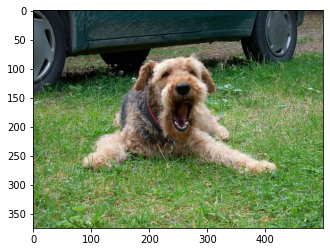

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

- 이 사진의 라벨은 `108`이다.

- 데이터가 준비되었으니 CAM을 생성하기 위해 미리 준비된 학습한 모델을 불러온다.

In [ ]:
import os
cam_model_path = '/content/drive/MyDrive/아이펠/GOING DEEPER/data/class_activation_map/data/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('슝=3')

슝=3


CAM을 생성하기 위해서는 

**(1) 특성 맵** <br>
**(2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치**<br>
**(3) 원하는 클래스의 출력값**이 필요하다.

- 또 이미지에서 <u>모델이 어떤 부분을 보는지 직관적으로 확인하려면</u> 네트워크에서 나온 **CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화**해야 한다.
- 이를 고려해서 `model`과 `item`을 받았을 때 <u>입력 이미지와 동일한 크기</u>의 CAM을 반환하는 함수를 만들어 준다.

<br>

- `generate_cam()` 을 구현하기 위해 아래에서는 `conv_ouputs`와 같이 <u>특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의</u>하고, feedforward를 거친 후 CAM을 계산하도록 구현한다.
- 마지막에는 입력 이미지의 크기에 맞춰 CAM을 `resize`

In [ ]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]  # 열
    height = item['image'].shape[0] # 행
    
    img_tensor, class_idx = normalize_and_resize_img(item)     # (1)

    # print(img_tensor)
    # print(class_idx)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])       # (2) 
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))    # axis=0일때, 맨 앞의 차원을 늘린다.    # (3)
    
    # print(conv_outputs)

    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]   #마지막 모델의 weight activation을 가져옵니다.    # (4)

    # print(class_weights)
    # print(class_weights.shape)
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):         
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]         # (5)
        
    # print(cam_image)

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

print('슝=3')

슝=3


|번호|코드 및 변수|설명|
|:---:|:---|:---|
|1|`img_tensor`|shape=(224, 224, 3)|
|2|`tf.keras.models.Model(input, output)`|input과 output을 넣어준다.|
||`[model.layers[-3].output, model.output]`|conv layer의 output(feature map)과 전체 모델의 output(classification) 두 가지 모두를 **cam_model의 output**으로 넣어준다.|
|3|`tf.expand_dims(image, axis=0)`|배열의 차원을 늘리는 메서드. **axis=0**이면 (224, 224, 3) 👉 **(1, 224, 224, 3)**|
||`conv_outputs`|shape=(1, 7, 7, 2048) 👉 바로 다음 줄에서 (0, 7, 7, 2048)로 변경. 그냥 (7,7,2048)과 같다|
|4|`class_weights`|activation map에서 각 픽셀별 가중치를 2차원 배열로 만들어서 변수에 할당. <br> shape = (2048, 120) 👉 **2048장의 feature map(채널)**과 **120개의 라벨이 있음**을 알 수 있다. <br>바로 뒤의 for문에서 `class_weights[:, class_idx]`은 각 feature map에서 `class_idx` 클래스 라벨에 해당하는 <br>가중치만 뽑아내는 코드이다. |
|5|`cam_image`|shape = (7, 7) 크기의 텐서 (`conv_outputs`의 0, 1번째 차원만 가져왔으므로) 👉 shape=(375, 500)으로 resize한다. 이미지 원래 크기|

<br>

👇 `cam_model.summary()`를 했을 때, 마지막 레이어 확인

![](https://media.vlpt.us/images/seona056/post/df5752fb-dcf0-4b17-b02d-a137a0bef2f1/image.png)

<br>

- 마지막 `dense layer`에서도 **출력이 120**인 것을 확인할 수 있다.
- 원래 분류 (classification) 모델이므로, 라벨이 **120개**라는 것을 다시 한 번 확인할 수 있다.

2) 만든 함수로 CAM 이미지를 생성합시다.
```
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
```



- 위에서 작성한 함수를 실행하면 아래와 같은 CAM을 얻을 수 있다. 
- 생각보다 위치를 정확하게 표현한다.

<br>

**☝ epoch=2로 학습한 모델 사용**

(375, 500)


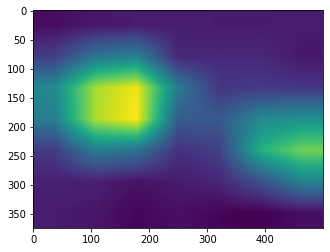

In [ ]:
cam_image = generate_cam(cam_model, item)
print(cam_image.shape)
plt.imshow(cam_image)
plt.show()

**✌ epoch=8로 학습한 모델 사용**

(375, 500)


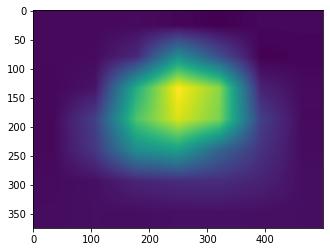

In [ ]:
cam_image = generate_cam(cam_model, item)
print(cam_image.shape)
plt.imshow(cam_image)
plt.show()

3) 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 `visualize_cam_on_image()` 함수를 만들어보세요.

<br>

- [webnautes님의 OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩](https://webnautes.tistory.com/1245)

<br>

```
def visualize_cam_on_image(image, cam_image):
    # TODO: blend image
    merged_image = None
    return merged_image
```
```
# visualize_cam_on_image() 함수 사용

type(item['image'].numpy())

origin_image = item['image'].numpy().astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
```

- CAM 이미지를 원본 이미지와 합쳐본다.
- 예제에서는 `cam_image`의 alpha값을 0.5로 설정했는데, **0.7**로 변경

In [ ]:
def visualize_cam_on_image(src1, src2, alpha=0.7):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('슝=3')

슝=3


**☝ epoch=2로 학습한 모델 사용**

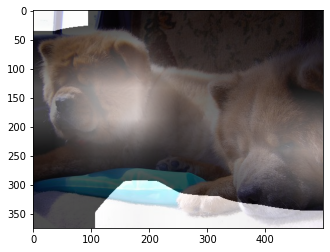

In [ ]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
# print(cam_image*255)
# print(cam_image_3channel.shape)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

- 두 마리 강아지의 얼굴에 cam이 표시된 것을 확인할 수 있다.

**✌ epoch=8로 학습한 모델 사용**

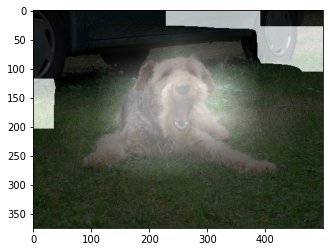

In [ ]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

- epoch=2에서 강아지 얼굴에만 cam이 표시된 것과 비교해서, 좀 더 강아지 몸 전체에 cam이 표시된 것을 확인할 수 있다.

# Grad-CAM 구현하기

1) 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.
```
def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None
    # TODO: generate grad_cam_image

    return grad_cam_image
```



- 새로운 이미지를 뽑아 본다.

40


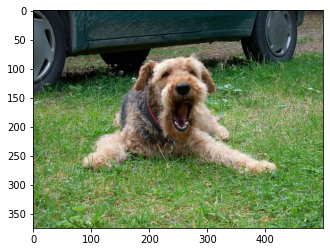

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()






- `grad_cam`은 **관찰을 원하는 레이어**와 **정답 클래스에 대한 예측값** 사이의 <u>그래디언트를 구하고, 여기에 GAP 연산을 적용함</u>으로써 관찰 대상이 되는 레이어의 **채널별 가중치**를 구한다. 
- 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(`weights`)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 `cam_image`를 얻는다. 👉 이 연산은 CAM과 동일

<br>

<u>모델의 전체 GAP 연산 바로 전의 레이어의 feature map</u>과 예측 라벨의 채널별 가중치를 가중합 했던 이전의 CAM과 달리, Grad-CAM은 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 `activation_layer`를 뽑아서 쓸 수 있도록 `activation_layer`의 이름을 받고 이를 활용하면 된다.

<br>

- 아래 `generate_grad_cam()`에서는 원하는 레이어의 `output`과 특정 클래스의 prediction 사이의 <u>그래디언트</u> `grad_val`을 얻고 이를 `weights`로 활용하도록 한다.

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝=3')

슝=3


2) 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.


- 여러 레이어의 feature map을 적용해 보았다.
- 레이어의 이름은 이전 스탭의 `cam_model.summary()` 결과에서 찾을 수 있다.
- `conv5_block3_3_conv`, `conv5_block3_3_bn`, `conv5_block3_add`, `conv5_block3_out` 
- 너무 앞쪽은 크게 의미가 없을 거라 생각했고, 출력 차원과 shape가 동일한 마지막 4개의 레이어의 output을 이용함.


**☝ epoch=2로 학습한 모델 사용**

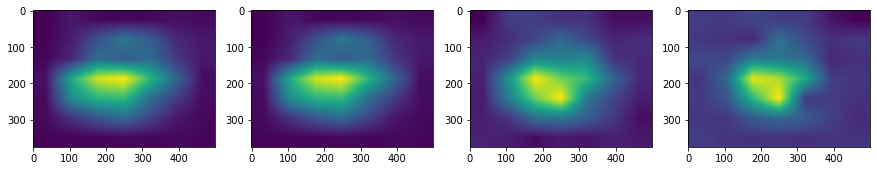

In [ ]:
plt.figure(figsize=(15,30))

plt.subplot(1, 4, 1)
grad_cam_image_conv = generate_grad_cam(cam_model, 'conv5_block3_3_conv', item)
plt.imshow(grad_cam_image_conv)

plt.subplot(1, 4, 2)
grad_cam_image_bn = generate_grad_cam(cam_model, 'conv5_block3_3_bn', item)
plt.imshow(grad_cam_image_bn)

plt.subplot(1, 4, 3)
grad_cam_image_add = generate_grad_cam(cam_model, 'conv5_block3_add', item)
plt.imshow(grad_cam_image_add)

plt.subplot(1, 4, 4)
grad_cam_image_out = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image_out)

plt.show()

- 세 번째 `conv5_block3_add`에서 부터 포커스가 맞춰지다가 다시 퍼지는 느낌이 든다고 생각했는데, 이 레이어에서는 `['conv5_block2_out[0][0]`과  `'conv5_block3_3_bn[0][0]'] `를 더하는 **레즈넷의 항등매핑**이 이루어지는 레이어였다.


**✌ epoch=8로 학습한 모델 사용**

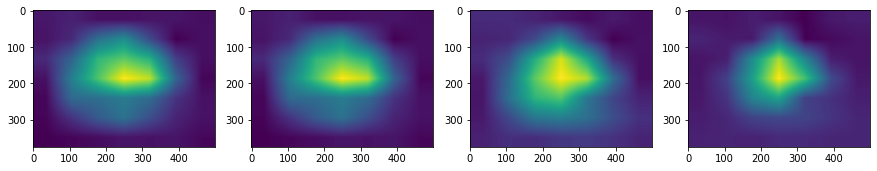

In [ ]:
plt.figure(figsize=(15,30))

plt.subplot(1, 4, 1)
grad_cam_image_conv = generate_grad_cam(cam_model, 'conv5_block3_3_conv', item)
plt.imshow(grad_cam_image_conv)

plt.subplot(1, 4, 2)
grad_cam_image_bn = generate_grad_cam(cam_model, 'conv5_block3_3_bn', item)
plt.imshow(grad_cam_image_bn)

plt.subplot(1, 4, 3)
grad_cam_image_add = generate_grad_cam(cam_model, 'conv5_block3_add', item)
plt.imshow(grad_cam_image_add)

plt.subplot(1, 4, 4)
grad_cam_image_out = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image_out)

plt.show()

- epoch=2로 학습한 것은 노란색으로 강아지를 포커싱한 영역이 넓었는데, epoch=8로 학습한 모델은 `add layer`를 거치고 난 뒤에도 비교적 강아지를 잘 포커싱하고 있는 것으로 보인다.

3) 위에서 만든 이미지 `visualize_cam_on_image()` 함수로 이미지를 시각화해 보세요.

**☝ epoch=2로 학습한 모델 사용**

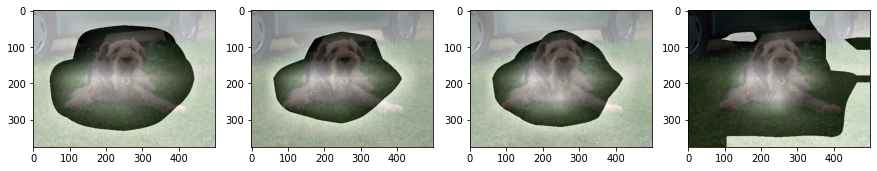

In [ ]:
origin_image = item['image'].astype(np.uint8)

plt.figure(figsize=(15,30))

plt.subplot(1, 4, 1)
grad_cam_image_conv_3channel = np.stack([grad_cam_image_conv*255]*3, axis=-1).astype(np.uint8)
blended_image_conv = visualize_cam_on_image(grad_cam_image_conv_3channel, origin_image)
plt.imshow(blended_image_conv)

plt.subplot(1, 4, 2)
grad_cam_image_bn_3channel = np.stack([grad_cam_image_bn*255]*3, axis=-1).astype(np.uint8)
blended_image_bn = visualize_cam_on_image(grad_cam_image_bn_3channel, origin_image)
plt.imshow(blended_image_bn)

plt.subplot(1, 4, 3)
grad_cam_image_add_3channel = np.stack([grad_cam_image_add*255]*3, axis=-1).astype(np.uint8)
blended_image_add = visualize_cam_on_image(grad_cam_image_add_3channel, origin_image)
plt.imshow(blended_image_add)

plt.subplot(1, 4, 4)
grad_cam_image_out_3channel = np.stack([grad_cam_image_out*255]*3, axis=-1).astype(np.uint8)
blended_image_out = visualize_cam_on_image(grad_cam_image_out_3channel, origin_image)
plt.imshow(blended_image_out)

plt.show()

- 위의 grad cam에서 노란색으로 표시된 부분이 label을 표시하는 것 같다

<br>

|번호|레이어|코멘트|
|:---:|:---:|:---|
|1|`conv layer`|cam 사진으로는 집중도 있게 강아지를 포커싱하는 듯 했는데, 생각보다 영역을 크게 잡음|
|2|`bn layer`|배치 정규화 이후의 모습이 가장 강아지를 잘 포커싱 하는 듯하다.|
|3|`add layer`|이전 블럭의 `out layer`의 output과 더해진 레이어여서 두 번째보다 살짝 영역이 넓어진 느낌|
|4|`out (activation) layer`|활성화 함수 적용 이후의 레이어인데, 제대로 포커싱을 못하고 있다.|

**✌ epoch=8로 학습한 모델 사용**

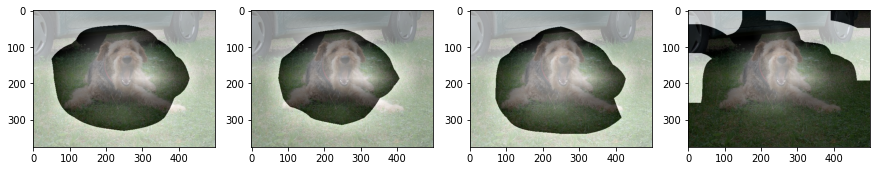

In [ ]:
origin_image = item['image'].astype(np.uint8)

plt.figure(figsize=(15,30))

plt.subplot(1, 4, 1)
grad_cam_image_conv_3channel = np.stack([grad_cam_image_conv*255]*3, axis=-1).astype(np.uint8)
blended_image_conv = visualize_cam_on_image(grad_cam_image_conv_3channel, origin_image)
plt.imshow(blended_image_conv)

plt.subplot(1, 4, 2)
grad_cam_image_bn_3channel = np.stack([grad_cam_image_bn*255]*3, axis=-1).astype(np.uint8)
blended_image_bn = visualize_cam_on_image(grad_cam_image_bn_3channel, origin_image)
plt.imshow(blended_image_bn)

plt.subplot(1, 4, 3)
grad_cam_image_add_3channel = np.stack([grad_cam_image_add*255]*3, axis=-1).astype(np.uint8)
blended_image_add = visualize_cam_on_image(grad_cam_image_add_3channel, origin_image)
plt.imshow(blended_image_add)

plt.subplot(1, 4, 4)
grad_cam_image_out_3channel = np.stack([grad_cam_image_out*255]*3, axis=-1).astype(np.uint8)
blended_image_out = visualize_cam_on_image(grad_cam_image_out_3channel, origin_image)
plt.imshow(blended_image_out)

plt.show()

- 막상 시각화를 해 보니 epoch=2로 학습한 모델과 크게 다르지 않아 보인다.

# 바운딩 박스 구하기

1) 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.


- 새로운 이미지를 뽑는다.

80


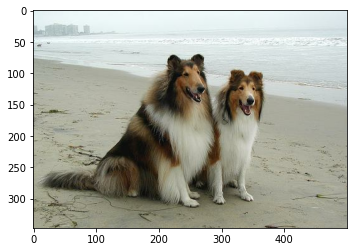

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

- 이전 스텝에서 사용했던 `generate_grad_cam()`함수를 이용해서 grad cam이미지를 생성한다.

**☝ epoch=2로 학습한 모델 사용**


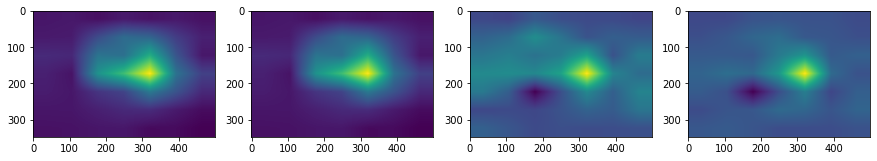

In [ ]:
grad_cam = []

grad_cam_image_conv = generate_grad_cam(cam_model, 'conv5_block3_3_conv', item)
grad_cam.append(grad_cam_image_conv)

grad_cam_image_bn = generate_grad_cam(cam_model, 'conv5_block3_3_bn', item)
grad_cam.append(grad_cam_image_bn)

grad_cam_image_add = generate_grad_cam(cam_model, 'conv5_block3_add', item)
grad_cam.append(grad_cam_image_add)

grad_cam_image_out = generate_grad_cam(cam_model, 'conv5_block3_out', item)
grad_cam.append(grad_cam_image_out)


plt.figure(figsize=(15,30))

for i, g in enumerate(grad_cam):
    plt.subplot(1, 4, i+1)
    plt.imshow(g)

    if i == len(grad_cam):
        plt.show()

**✌ epoch=8로 학습한 모델 사용**

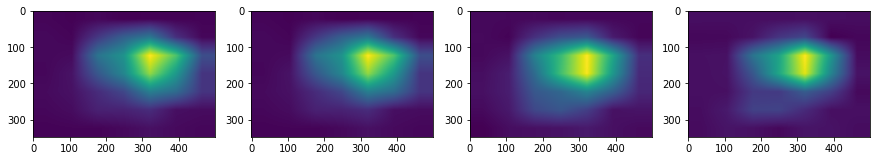

In [ ]:
grad_cam = []

grad_cam_image_conv = generate_grad_cam(cam_model, 'conv5_block3_3_conv', item)
grad_cam.append(grad_cam_image_conv)

grad_cam_image_bn = generate_grad_cam(cam_model, 'conv5_block3_3_bn', item)
grad_cam.append(grad_cam_image_bn)

grad_cam_image_add = generate_grad_cam(cam_model, 'conv5_block3_add', item)
grad_cam.append(grad_cam_image_add)

grad_cam_image_out = generate_grad_cam(cam_model, 'conv5_block3_out', item)
grad_cam.append(grad_cam_image_out)


plt.figure(figsize=(15,30))

for i, g in enumerate(grad_cam):
    plt.subplot(1, 4, i+1)
    plt.imshow(g)

    if i == len(grad_cam):
        plt.show()

- 아래 `get_bbox()` 함수는 바운딩 박스를 만들기 위해서 `score_thresh`를 받아 역치값 이하의 바운딩 박스는 없앤다.
- 그 다음 OpenCV의 `findContours()`와 `minAreaRect()`로 사각형을 찾아준다.
- 이때 `rotated_rect` 라는 회전된 바운딩 박스를 얻을 수 있다. 
- `boxPoints()`로 이를 꼭지점으로 바꾸어 준다.
- 마지막에는 `int` 자료형으로 변환해 준다.

In [ ]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝=3')

슝=3


2) 1)에서 얻은 바운딩 박스를 시각화해 보세요.

**☝ epoch=2로 학습한 모델 사용**

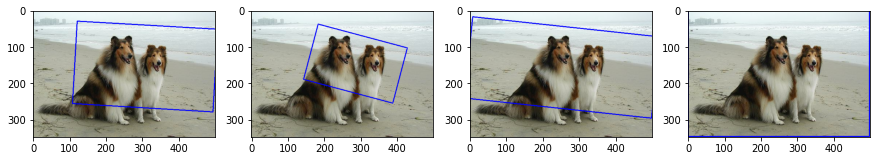

In [ ]:
plt.figure(figsize=(15, 30))

for i, g in enumerate(grad_cam):
    
    plt.subplot(1, 4, i+1)
    
    rect = get_bbox(g)
    image = copy.deepcopy(item['image'])
    image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
    plt.imshow(image)

    if i == len(grad_cam):
        plt.show() 

- 바운딩 박스에서도 여전히 **두 번째** `bn layer`가 가장 포커싱이 잘 되어 있다.
- 아쉬운 점은 다리와 몸통까지 완벽하게 포커싱된 이미지는 없었다는 것. 강아지의 얼굴을 위주로 포커싱 하는 듯 하다.

- 예제 실습에서 만들어 보았던 CAM 이미지로 얻은 바운딩 박스이다.

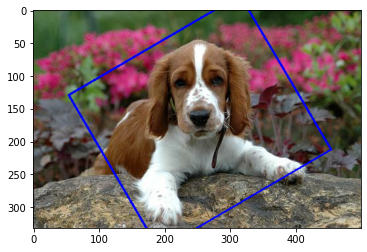

In [ ]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

- 오히려 grad cam 보다 강아지 몸통 전체를 더 잘 잡고 있는 것으로 보인다. 
- 다음 챕터 IoU구하기에서 지표를 확인해 보아야겠다.

**✌ epoch=8로 학습한 모델 사용**

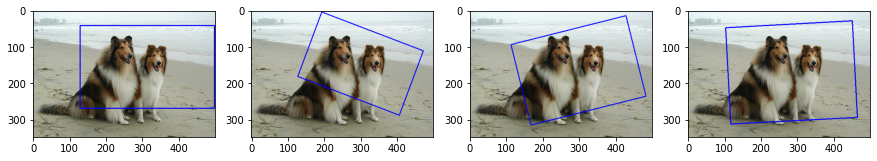

In [ ]:
plt.figure(figsize=(15, 30))

for i, g in enumerate(grad_cam):
    
    plt.subplot(1, 4, i+1)
    
    rect = get_bbox(g)
    image = copy.deepcopy(item['image'])
    image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
    plt.imshow(image)

    if i == len(grad_cam):
        plt.show() 

- epoch=2로 학습한 모델 보다 훨씬 더 포커싱을 잘 하고 있는 모습이다.
- 특히 세 번째, 네번째는 epoch=2 모델에서는 거의 사진 전체를 인식하는게 아닌가 싶을 정도었는데, 꽤나 강아지를 잘 파악하고 있는 것으로 보인다.
- 두 번째 `bn layer`는 epoch=2에서와 마찬가지로 강아지의 얼굴에 집중도가 있는 듯하다.

# IoU 구하기

1) **정답 바운딩 박스(ground truth)와 예측값 바운딩 박스(prediction box)** 두 가지를 이용해서 IoU를 계산하는 `get_iou()` 함수를 만들어 주세요.
```
def get_iou(gt_bbox, pred_bbox):
    iou = None
    # TODO: get iou between two bbox
    return iou
```



## Intersection Over Union

 정답 데이터인 바운딩 박스와 cam으로 구한 바운딩 박스를 어떻게 비교, 평가할 수 있을까?

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-3-P-3.max-800x600.jpg)

<br>

- **IoU(Intersection over Union)**는 두 영역의 교집합인 **intersection** 영역의 넓이를 두 영역의 합집합인 **union** 영역으로 나누어준 값이다.
- 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, <u>영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로,</u> 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 된다.


In [ ]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


- 위에서 구했던 `rect`를 minmax `bbox` 형태로 치환한다.

**☝ epoch=2로 학습한 모델 사용**

In [ ]:
pred_bbox = []

for g in grad_cam:    
    rect = get_bbox(g)
    p_bbox = rect_to_minmax(rect, item['image'])    
    pred_bbox.append(p_bbox)

pred_bbox

[[0.08645533141210375, 0.216, 0.8011527377521613, 1.014],
 [0.10951008645533142, 0.288, 0.7319884726224783, 0.858],
 [0.05187319884726225, -0.032, 0.8501440922190202, 1.044],
 [0.0, 0.0, 0.9942363112391931, 0.996]]

**✌ epoch=8로 학습한 모델 사용**

In [ ]:
pred_bbox = []

for g in grad_cam:    
    rect = get_bbox(g)
    p_bbox = rect_to_minmax(rect, item['image'])    
    pred_bbox.append(p_bbox)

pred_bbox

[[0.12103746397694524, 0.258, 0.7723342939481268, 0.996],
 [0.01440922190201729, 0.256, 0.8270893371757925, 0.946],
 [0.043227665706051875, 0.224, 0.9048991354466859, 0.966],
 [0.08357348703170028, 0.206, 0.8962536023054755, 0.93]]

- 이 데이터의 ground truth bbox를 확인해 본다.

In [ ]:
item['objects']['bbox']

array([[0.19596542, 0.02      , 0.9048991 , 0.578     ],
       [0.26224783, 0.584     , 0.89048994, 0.736     ]], dtype=float32)

- CAM 추론 결과로 얻어진 bbox와 ground truth bbox가 얼마나 유사한지를 IoU를 계산해서 확인해 본다.

In [ ]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('슝=3')

슝=3


2) CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

**☝ epoch=2로 학습한 모델 사용**

- grad cam으로 구한 IoU



In [ ]:
for p_bbox in pred_bbox:
    iou = get_iou(p_bbox, item['objects']['bbox'][0])
    print(iou)

0.2933413588004529
0.2612764467660049
0.41038186778028823
0.39947618159625564


- IoU 지표는 1에 가까울 수록 바운딩 박스를 잘 찾았다고 볼 수 있다. (예측값과 정답 박스가 많이 겹쳐져있다는 뜻이기 때문)
- 지금까지 두 번째, `bn layer`에서 가장 포커싱이 잘 되었다고 느꼈었는데, 오히려 지수는 세 번째 `add layer`에서 가장 높았다.
- 다시 사진을 보니, `bn layer`에서는 얼굴을 가깝게 포커싱하여, 아까도 언급했었던 몸통을 잘 인식하지 못하는 점 때문에 강아지 bbox 면적과의 교집합이 적었던 것 같다.
- 반면 `add layer`에서는 배경을 넓게 포함하고 있어서 육안으로 보기에는 제대로 포커싱이 안된 것 처럼 느껴졌지만, 오히려 bbox과의 교집합은 더 많았던 것으로 이해되었다.
- 생각보다 지표가 높게 나온 `out layer`도 마찬가지라고 생각함. 하지만 `out laer`는 수치상으로 높게 나왔다고 해서, `bn layer`보다 더 정확한 포커싱이 이루어졌다고는 절대 말할 수 없다고 생각한다.

- 예제 실습에서 cam으로 구한 IoU

In [ ]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6199742123945472

- cam 바운딩 박스 시각화에서도 언급했듯이, grad cam에서보다 강아지의 얼굴 뿐만 아니라 몸통까지 잘 포커싱하고 있었다.
- 예상했던 대로 grad cam의 IoU보다 높은 수치를 보이고 있다.

**✌ epoch=8로 학습한 모델 사용**

In [ ]:
for p_bbox in pred_bbox:
    iou = get_iou(p_bbox, item['objects']['bbox'][0])
    print(iou)

0.26660445869110355
0.2698427280997174
0.3201123360240732
0.3600860416599793


- 육안으로 보기에는 epoch=2 모델보다 훨씬 강아지를 잘 포커싱하고 있다고 생각하는데, 전체적인 지표가 epoch=2 모델에 비해 낮게 나왔다.

# 회고

## 알게된 점

### 학습된 모델의 세부사항 변경

공부한 내용이라고 하기엔 거창하고 새로 알게된 내용을 정리하였다.

<br>

- 지난 프로젝트 `CV-04`에서 ResNet 50에 shakedrop을 사용해 보고 싶었는데, 어떻게 적용해야할 지 몰라서 그냥 기본 코드만 사용하고 제출하였다.
- 이번 프로젝트를 진행하면서 보니, 이미 학습된 모델에서도 세부적인 것들을 변경할 수 있었다.
- 주말이라도 이 코드를 참고하여 한번 더 시도해 봐야겠다고 생각했다.
```
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)
```


## 루브릭 평가 지표를 맞추기 위해 시도한 것들

|평가문항|상세기준|
|:------|:---|
|1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?|ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.|
|2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?|CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.|
|3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?|CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.|

- cam_model용 ResNet 50은 예제에서 구현하여 파일로 저장한 모델 **cam_model1.h5**을 사용하였다.
- 처음에는 epoch=2로 학습된 모델을 사용하였고, 두 번째로는 epoch=5로 학습된 모델을 사용하였다.
- 시각화와 성능 분석을 진행하면서, 의외로 grad cam 보다 일반 cam이 더 좋은 성능이 나온 것이 신기했다.
- 자세한 분석 결과는 각 챕터 말미에 기술

## 어려웠던 점

### 1. 코드 분석

강상권님의 코드가 너무 가독성이 떨어진다.

설명도 없고, 그냥 함수로 뭉탱이되어 있는데, 파이썬을 잘 못해서 그런지 중간 출력이 어떻게 되는지 이해를 하지 못했다. 

특히 `def generate_cam(model, item)` 함수의 코드가 너무 헷갈려서... 하나하나 검색하고 출력 결과를 확인해보느라 시간이 많이 걸렸다. 

아직은 파이썬 초보인데... 설명도 안해주고 너무한거 아닌가요 상권님....


### 2. IoU 지표

이번 프로젝트는 이론 내용이 어렵지는 않았지만, 지표의 결과 분석에 의아함이 있었다.

<br>

특히 `epoch=2` 모델과 `epoch=8`모델의 성능차이가, 육악으로 보기에는 `epoch=8`모델이 훨씬 로컬라이징을 잘 했다고 생각했는데, 수치상으로는 그렇지 않았다.

<br>

딥러닝을 배우면서 종종 느끼게 되지만, 어떤 분석을하고 결과를 도출해 낼 때 무조건 성능 지표만 고려해서 결론을 도출해서는 안될 것 같다는 생각이 들곤한다.

<br>

특히 고객 서비스를 제공하는 업무를 맡게 된다면, 지금처럼 사람의 육안으로는 오히려 성능이 떨어져 보이는 결과가 성능 지표의 수치상으로는 더 좋게 나타나는 경우는 어떤식으로 서비스를 제공하고 고객을 설득시킬 수 있는지를 고민해 볼 필요가 있을듯하다.

<br>

인공지능을 배우는 나의 입장에서는 논리적으로 육안으로 보기에는 안좋아보이지만, 이러저러한 이유로 성능이 더 좋다는 설명을 듣는다면 납득하고 공부할 주제가 되지만, 고객들은 그런 설명을 기꺼워하지 않을지도 모른다.<br>
오히려 그런 고객들을 설득시키는 대신, 일부러 성능 지표가 낮은 모델을 적용시켜야했던 사례도 있을 것이라는 생각도 하게 되었다.

<br>

프로젝트와 관련된 여러 비지니스 케이스들도 접해볼 기회가 있다면 좋겠다.(꼭 이번 프로젝트와 관련된 케이스가 아니라도!)

## I wish...

![](https://images.velog.io/images/seona056/post/b47e596f-c965-49bd-9b5a-75c582aac020/image.png)

이제 그만 나와주세요
